## Calorimeter discriminator test
### Author: stephen.menary@manchester.ac.uk

---

### Step 1)  Grab a dataset of labelled showers and rings

---

In [6]:
#  Create simulated dataset of rings and showers
#  -  datapoints are labelled by momentum

import Tools.shower_test_tools as tools

import numpy as np

num_pixels      = 51
num_simulations = 1000

TRAIN_X, TRAIN_Y, VAL_X, VAL_Y, TEST_X, TEST_Y = tools.get_labelled_dataset(num_pixels=num_pixels, num_simulations=num_simulations)

print(f"  TRAINING DATASET with size {len(TRAIN_X)}")
print(f"VALIDATION DATASET with size {len(VAL_X  )}")
print(f"      TEST DATASET with size {len(TEST_X )}")

1000 rings loaded successfully from file
1000 showers loaded successfully from file
  TRAINING DATASET with size 1000
VALIDATION DATASET with size 500
      TEST DATASET with size 500


---

### Step 2)  Plot some examples of our images

---

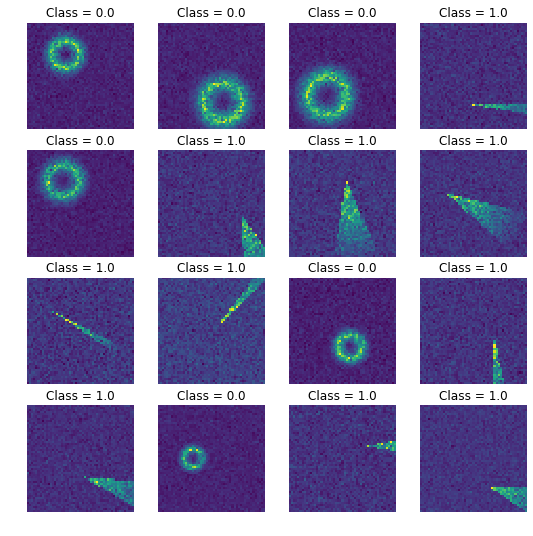

In [2]:
#  Plot some examples of datapoints
#

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,9))
for idx, (im, label) in enumerate(zip(TRAIN_X[:16], TRAIN_Y[:16])) :
    z = im[:,:,0]
    plt.subplot(4, 4, 1+idx)
    plt.imshow(z)
    plt.axis('off')
    plt.title(f"Class = {label[0]:.0f}")
plt.show()

---

### Step 3)  Create a CNN discriminator network

---

In [3]:
#  Create discriminator network
#

from keras.layers import Dense, Flatten, Conv2D
from keras.models import Model, Sequential

def create_discriminator_network () :
    model = Sequential()
    model.add(Conv2D(15, kernel_size=3, activation="relu", input_shape=(num_pixels, num_pixels, 1)))
    model.add(Conv2D(5, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(2, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_discriminator_network()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


---

### Step 4)  Train the network

---

In [4]:
#  Fit the training data
#  - using early stopping, and storing best solution
#

from keras.callbacks import EarlyStopping, ModelCheckpoint

model.fit(TRAIN_X, 
          TRAIN_Y, 
          validation_data=(VAL_X, VAL_Y), 
          epochs=100, 
          callbacks=[EarlyStopping(monitor='val_accuracy', patience=10),
                     ModelCheckpoint('.model.hdf5', save_best_only=True, monitor='val_accuracy')])

model.load_weights('.model.hdf5')

Instructions for updating:
Use tf.cast instead.
Train on 1000 samples, validate on 500 samples
Epoch 1/100
1000/1000 [==============================] - 2s 2ms/step - loss: 1.1876 - accuracy: 0.5090 - val_loss: 0.6629 - val_accuracy: 0.5460
Epoch 2/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5504 - accuracy: 0.7040 - val_loss: 0.5398 - val_accuracy: 0.7440
Epoch 3/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2207 - accuracy: 0.9240 - val_loss: 0.2852 - val_accuracy: 0.8820
Epoch 4/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0465 - accuracy: 0.9910 - val_loss: 0.1732 - val_accuracy: 0.9440
Epoch 5/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0107 - accuracy: 0.9990 - val_loss: 0.1404 - val_accuracy: 0.9480
Epoch 6/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.1325 - val_accuracy: 0.9560
Epoch 7/100
1000/1000 [============

---

### Step 5)  Make predictions using the test data

---

In [7]:
#  Make predictions on test dataset
#

def make_one_hot (v) :
    max_idx, max_val = 0, 0.
    for idx, val in enumerate(v) :
        if val < max_val : continue
        max_idx, max_val = idx, val
    ret = np.zeros(shape=v.shape)
    ret[max_idx] = 1.
    return ret

test_predictions = model.predict(TEST_X)
for i in range(len(test_predictions)) :
    test_predictions[i] = make_one_hot(test_predictions[i])

---

### Step 6)  Plot some datapoints along with real and predicted classes

---

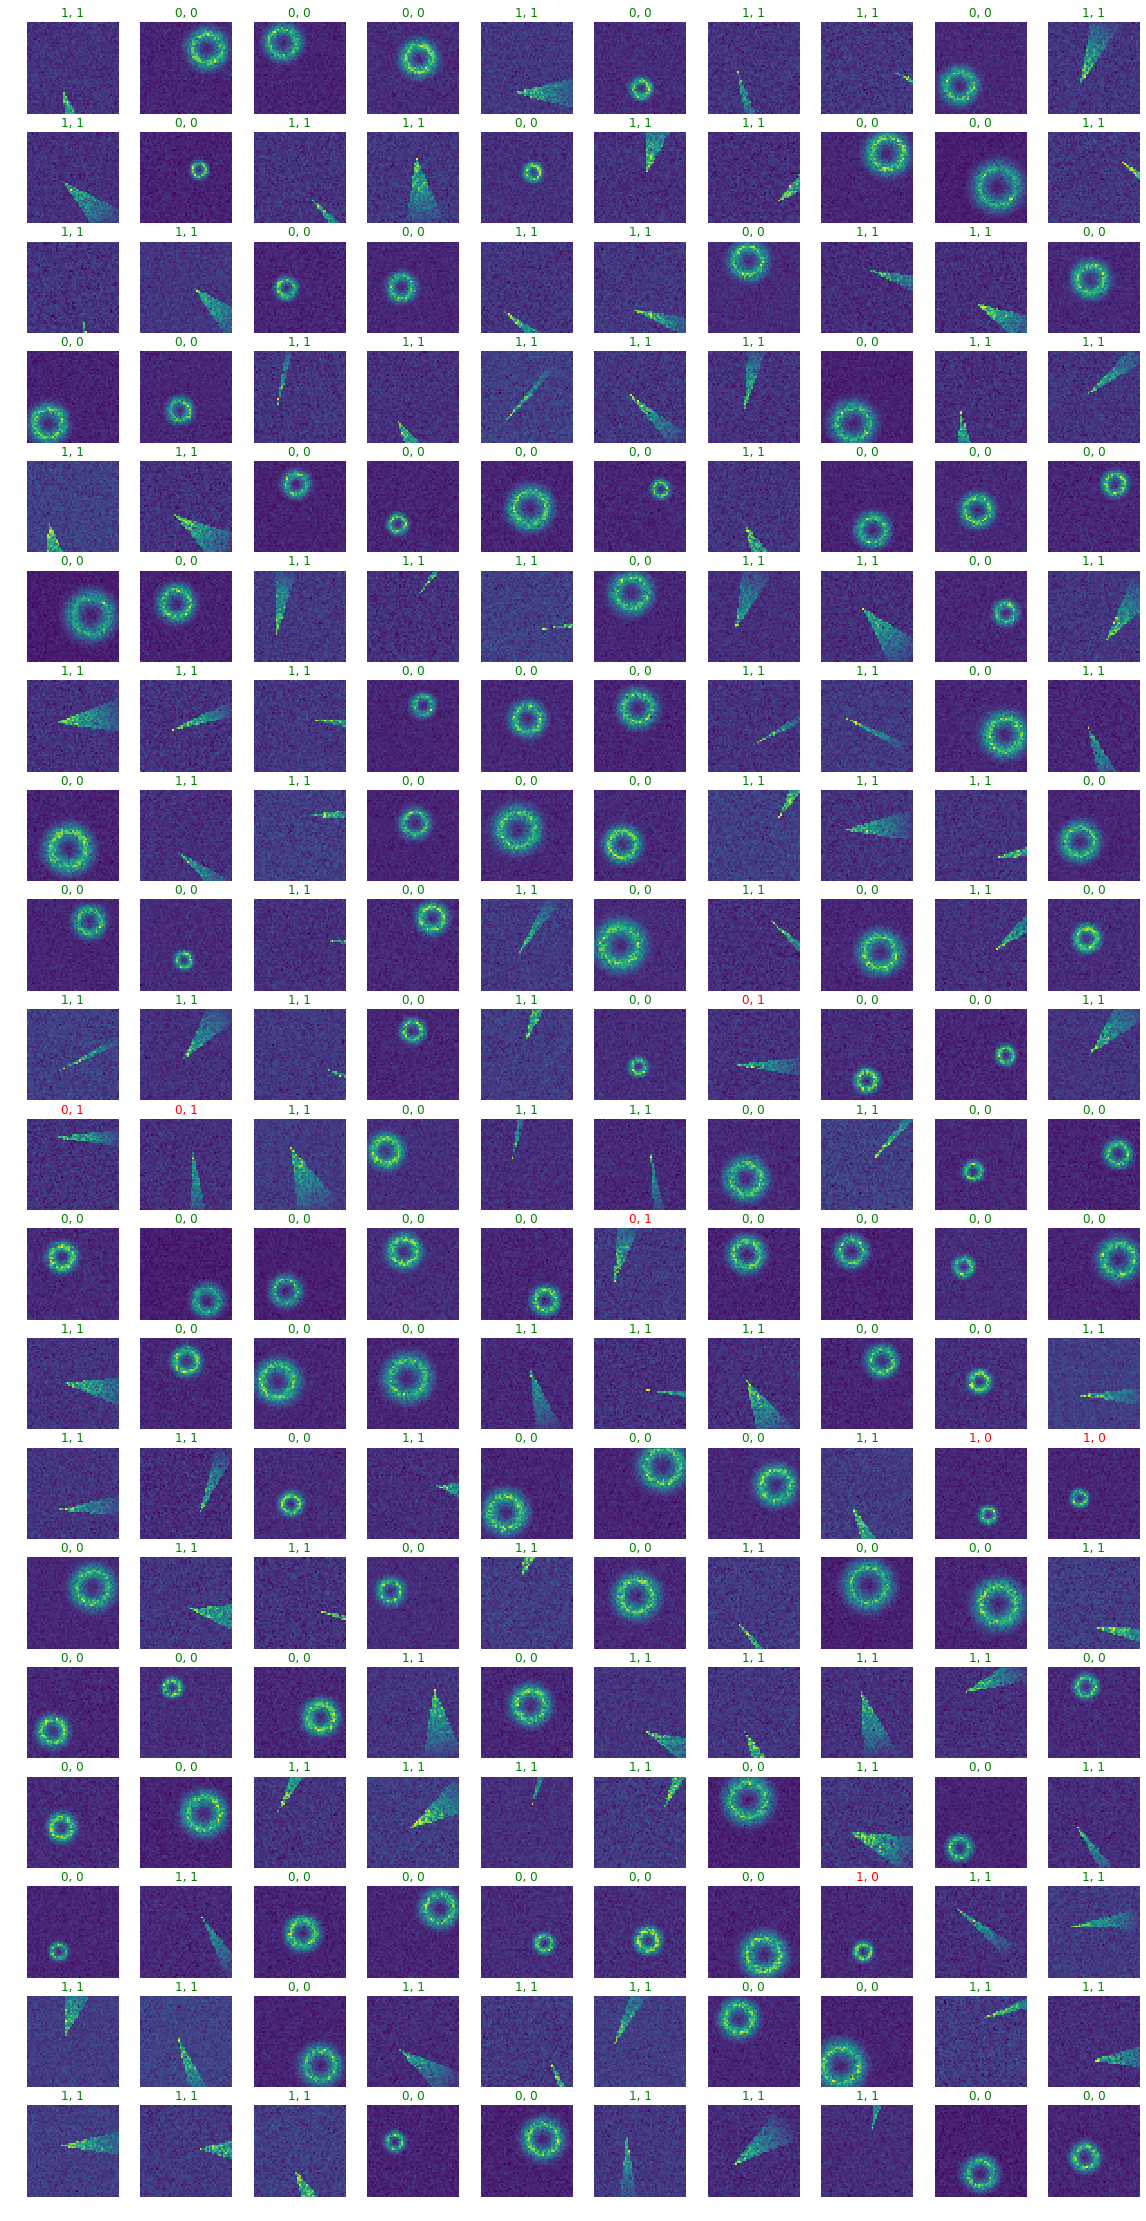

In [8]:
#  Plot some of the predictions
#

fig = plt.figure(figsize=(20,40))
for idx, (im, label, pred) in enumerate(zip(TEST_X[:200], TEST_Y[:200], test_predictions[:200])) :
    z = im[:,:,0]
    plt.subplot(20, 10, 1+idx)
    plt.imshow(z)
    plt.axis('off')
    if pred[0] == label[0] :
        plt.title(f"{pred[0]:.0f}, {label[0]:.0f}", color="g")
    else :
        plt.title(f"{pred[0]:.0f}, {label[0]:.0f}", color="r")
plt.show()

---

### Step 7)  Calculate the prediction efficiency

---

In [9]:
#  Calculate the prediction efficiency on the test dataset
#

n_wrong = 0
for label, pred in zip(TEST_Y, test_predictions) :
    if label[0] == pred[0] : continue
    n_wrong = n_wrong + 1
print(f"Test accuracy is {100.*(1.-(n_wrong/len(TEST_Y))):.0f}%")

Test accuracy is 96%
